# GUMDPs: The impact of the number of trials

This ipynb is similar to `number_of_trials.ipynb` but herein we consider noisy transition matrices, i.e., there is a non-zero probability (`epsilon`) that, at each timestep, the agent randomly transitions to an arbitrary state. This ensures that, under any policy, the induced Markov chain has at most one recurrent class since all states are reachable from any other state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import itertools

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

#### Auxiliary functions

In [2]:
def compute_d_pi(mdp, policy):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    P_pi = np.zeros((nS, nS))
    
    for a in range(nA):
        P_pi += np.dot(np.diag(policy[:,a]), mdp["P"][a])

    d_S = (1 - mdp["gamma"]) * np.dot(mdp["p_0"], np.linalg.inv(np.eye(nS) - mdp["gamma"] * P_pi))
    d_pi = np.dot(np.diag(d_S), policy)
    
    return d_pi

In [3]:
def sample_trajectory(mdp, policy, traj_length):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s = np.random.choice(mdp["states"], p=mdp["p_0"])

    for t in range(traj_length):
        states.append(s)

        a = np.random.choice(mdp["actions"], p=policy[s])
        actions.append(a)

        s =  np.random.choice(mdp["states"], p=mdp["P"][a,s,:])

    return states, actions

In [4]:
def estimate_d_pi_from_trajectory(mdp, trajectory_states, trajectory_actions):
    # Args:
    # mdp - MDP specification.
    # trajectory_states - list with sampled states.
    # trajectory_actions - list with sampled actions.
    
    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += mdp["gamma"]**t * 1

        d_hats.append(((1 - mdp["gamma"])/(1 - mdp["gamma"]**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [5]:
def estimate_f_d_pi_from_samples(mdp, policy, N, K, max_traj_length):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # N - number of times K trajectories are sampled.
    # K - number of trajectories to sample.
    # max_traj_length - the maximum length of each sampled trajectory.

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(mdp, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(mdp, traj_states, traj_actions)
        d_hat = d_hat / K

        # Compute f(d_hat).
        d_hat_flattened = d_hat.reshape((max_traj_length,-1)) # [max_traj_length, nS, nA]
        f_d_hat = np.array([mdp["f"](x) for x in d_hat_flattened])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [6]:
def mean_ci(samples: np.ndarray, num_resamples: int=25_000):
    # Point estimation.
    point_estimate = np.mean(samples)
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True)
    point_estimations = np.mean(resampled, axis=0)
    confidence_interval = [np.percentile(point_estimations, 5),
                           np.percentile(point_estimations, 95)]
    return confidence_interval

In [7]:
GLOBAL_DATA_ESTIMATED = {}
GLOBAL_DATA_TRUE = {}

#### Teleporting probability (epsilon):

In [8]:
epsilon = 0.05

## Entropy maximization

#### $f(d_\pi) = -d_\pi^\top \log(d_\pi)$

In [9]:
# Define MDP (taken from https://arxiv.org/pdf/2202.01511.pdf - Fig. 3 (a))
mdp = {}
mdp["states"] = [0,1,2]
mdp["actions"] = [0,1] # Action 0 = left, action 1 = right
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0,0.0]
mdp["P"] = epsilon * (np.ones((2,3,3)) / 3) + (1-epsilon) * np.array([[[0,1,0],[0,1,0],[1,0,0]],[[0,0,1],[1,0,0],[0,0,1]]]) 
mdp["f"] = lambda x: np.dot(x, np.log(x + 1e-07))

In [10]:
print(mdp["P"])

[[[0.01666667 0.96666667 0.01666667]
  [0.01666667 0.96666667 0.01666667]
  [0.96666667 0.01666667 0.01666667]]

 [[0.01666667 0.01666667 0.96666667]
  [0.96666667 0.01666667 0.01666667]
  [0.01666667 0.01666667 0.96666667]]]


In [11]:
policy_1 = np.array([[0.5,0.5], [0.0,1.0], [1.0,0.0]])

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [12]:
d_pi_1 = compute_d_pi(mdp, policy_1)
print("f(d_\pi) =", mdp["f"](d_pi_1.flatten()))

f(d_\pi) = -1.329660948854848


#### Compute $f_{K,H}(\pi) = \mathbb{E}_{\mathcal{T}_K } \left[ f\left(\hat{d}_{\mathcal{T}_K, H} \right) \right]$

In [13]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy_1, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)

(2, 20)


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [14]:
gammas = [0.2,0.4,0.6,0.8,0.99]
max_traj_length = 500 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy_1, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    d_pi_1 = compute_d_pi(mdp, policy_1)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.99
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.99


In [15]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.99])
dict_keys([1, 2, 5, 10])
(100, 500)


In [16]:
GLOBAL_DATA_ESTIMATED["entropy"] = estimated_fs_dict
GLOBAL_DATA_TRUE["entropy"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


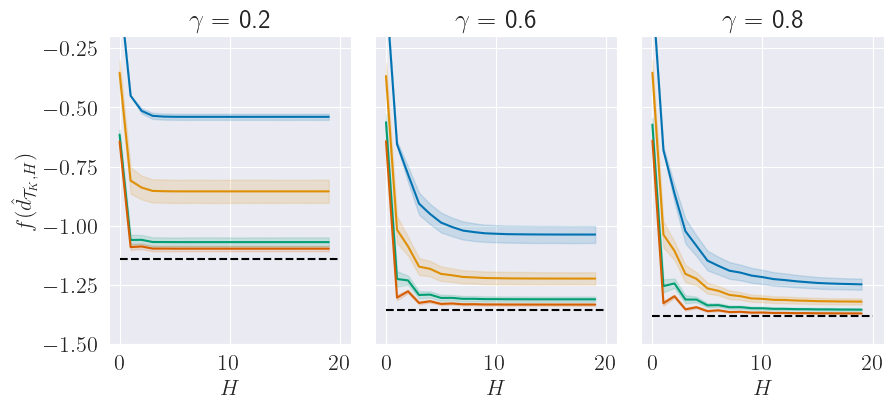

In [17]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]
        
        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-1.5,-0.2])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/noisy_entropy_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

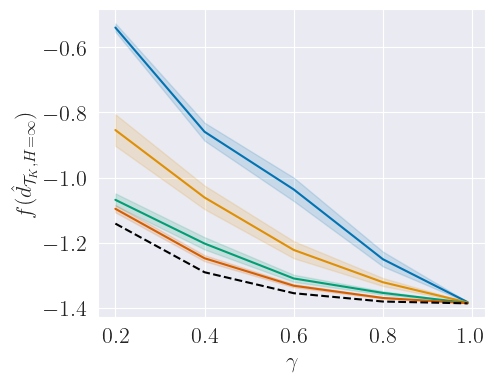

In [18]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/noisy_entropy_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
# Put a legend below the current axis.
"""legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
        fancybox=True, shadow=True, ncol=4)

# Export only legend.
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5)
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
export_legend(legend)"""

## Imitation learning

#### $f(d_\pi) = KL(d_\pi | d_\beta)$

In [20]:
# Define MDP (taken from https://arxiv.org/pdf/2202.01511.pdf - Fig. 3 (c))
mdp = {}
mdp["states"] = [0,1]
mdp["actions"] = [0,1] # Action 0 = left, action 1 = right
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0]
mdp["P"] = epsilon * (np.ones((2,2,2)) / 2) + (1-epsilon) * np.array([[[1.0,0.0],[1.0,0.0]],[[0.0,1.0],[0.0,1.0]]])

In [22]:
print(mdp["P"])

[[[0.975 0.025]
  [0.975 0.025]]

 [[0.025 0.975]
  [0.025 0.975]]]


In [23]:
# Define policy.
policy = np.array([[0.6,0.4], [0.3,0.7]])

# Define behavior policy.
beta = np.array([[0.5,0.5], [0.5,0.5]])

# Define objective function.
d_beta = compute_d_pi(mdp, beta).flatten()
mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [24]:
d_pi = compute_d_pi(mdp, policy)
print("f(d_\pi) =", mdp["f"](d_pi.flatten()))

f(d_\pi) = 0.03532933443616735


#### Compute $\mathcal{F}_{K,H}(\pi) = \mathbb{E}_{\mathcal{T}_K } \left[ f\left(\hat{d}_{\mathcal{T}_K, H} \right) \right]$

In [25]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)
print(f_estimated)

(2, 20)
[[0.30781739 0.02949157 0.03465731 0.04000901 0.03751076 0.03716727
  0.03600226 0.03595069 0.03596864 0.03610463 0.03611637 0.03604803
  0.03602786 0.03603634 0.03603709 0.03603922 0.03604046 0.03604104
  0.03604149 0.03604158]
 [0.30781739 0.02949157 0.04445282 0.03433543 0.03248403 0.03131827
  0.03064412 0.02970579 0.02926285 0.02898596 0.02887828 0.02885458
  0.02885043 0.02884087 0.02883609 0.02883466 0.02883302 0.02883133
  0.0288308  0.02883074]]


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [26]:
gammas = [0.2,0.4,0.6,0.8,0.99]
max_traj_length = 500 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    
    # Define objective function (since gamma changed d_beta changes).
    d_beta = compute_d_pi(mdp, beta).flatten()
    mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))
    
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val

    # Define objective function (since gamma changed d_beta changes).
    d_beta = compute_d_pi(mdp, beta).flatten()
    mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))
    
    d_pi_1 = compute_d_pi(mdp, policy)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.99
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.99


In [27]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.99])
dict_keys([1, 2, 5, 10])
(100, 500)


In [28]:
GLOBAL_DATA_ESTIMATED["imitation"] = estimated_fs_dict
GLOBAL_DATA_TRUE["imitation"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


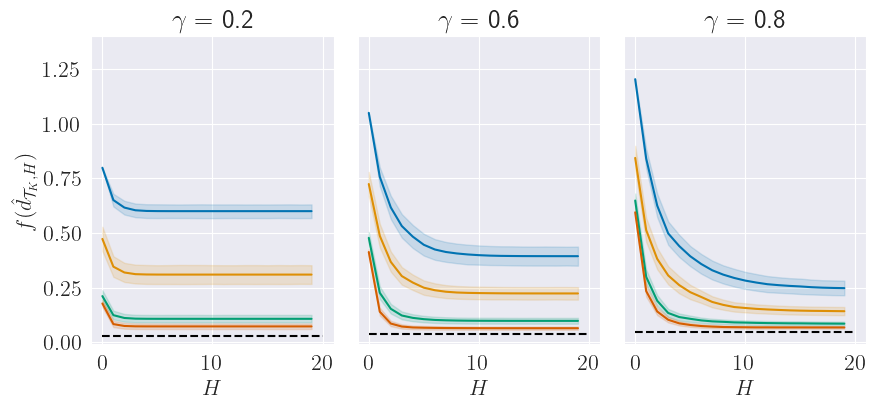

In [29]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]

        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-0.01,1.4])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/noisy_imitation_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

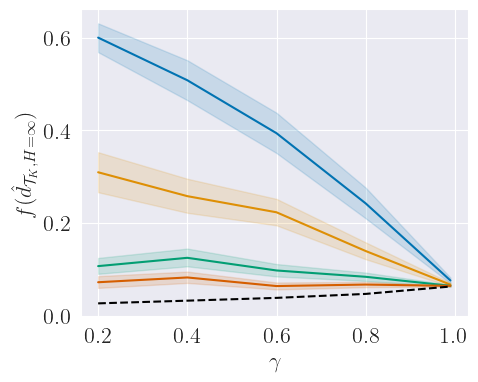

In [30]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/noisy_imitation_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Quadratic minimization

In [9]:
# Define MDP.
mdp = {}
mdp["states"] = [0,1,2]
mdp["actions"] = [0,1] # Action 0 = up, action 1 = down
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0,0.0]
mdp["P"] = epsilon * (np.ones((2,3,3)) / 3) + (1-epsilon) * np.array([[[0,1,0],[0,1,0],[0,0,1]],[[0,0,1],[0,1,0],[0,0,1]]])

def obj(d):
    d_s1 = d[2] + d[3] # d(s_1) = d(s_1,a_0) + d(s_1,a_1)
    d_s2 = d[4] + d[5] # d(s_2) = d(s_2,a_0) + d(s_2,a_1)
    return 1*d_s1**2 + 0.5*d_s2**2
mdp["f"] = obj

In [10]:
print(mdp["P"])

[[[0.01666667 0.96666667 0.01666667]
  [0.01666667 0.96666667 0.01666667]
  [0.01666667 0.01666667 0.96666667]]

 [[0.01666667 0.01666667 0.96666667]
  [0.01666667 0.96666667 0.01666667]
  [0.01666667 0.01666667 0.96666667]]]


In [11]:
# Define policy.
policy = np.array([[0.5,0.5], [0.5,0.5], [0.5,0.5]])

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [12]:
d_pi = compute_d_pi(mdp, policy)
print("f(d_\pi) =", mdp["f"](d_pi.flatten()))

f(d_\pi) = 0.09065104166666671


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [14]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)
print(f_estimated)

(2, 20)
[[0.         0.04888889 0.08081633 0.09582222 0.10301769 0.10530108
  0.10583421 0.10610627 0.10624362 0.10631262 0.1063472  0.10636451
  0.10637317 0.1063775  0.10637967 0.10638075 0.10638129 0.10638141
  0.10638168 0.10638182]
 [0.         0.04888889 0.08081633 0.09582222 0.10301769 0.10653565
  0.10827454 0.10913895 0.10933567 0.10955083 0.10965833 0.10969257
  0.10970969 0.10971825 0.10972253 0.10972467 0.10972574 0.10972627
  0.10972654 0.10972675]]


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [15]:
gammas = [0.2,0.4,0.6,0.8,0.999]
max_traj_length = 1_000 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    d_pi_1 = compute_d_pi(mdp, policy)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.999
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.999


In [16]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.999])
dict_keys([1, 2, 5, 10])
(100, 1000)


In [17]:
GLOBAL_DATA_ESTIMATED["quadratic"] = estimated_fs_dict
GLOBAL_DATA_TRUE["quadratic"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


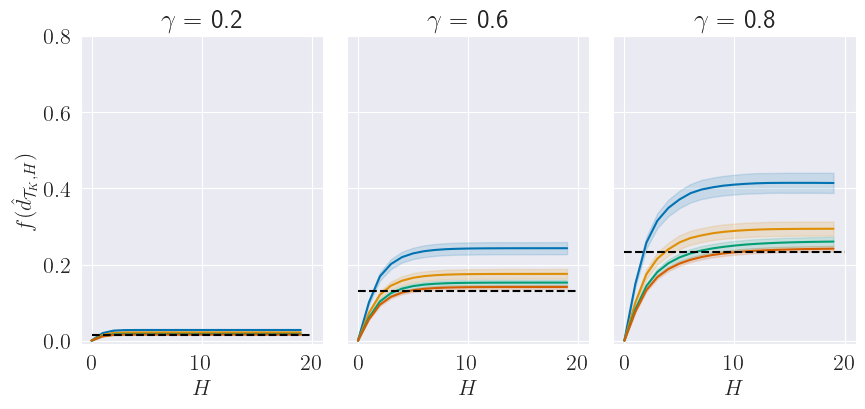

In [18]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]
        
        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-0.01,0.8])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/noisy_quadratic_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

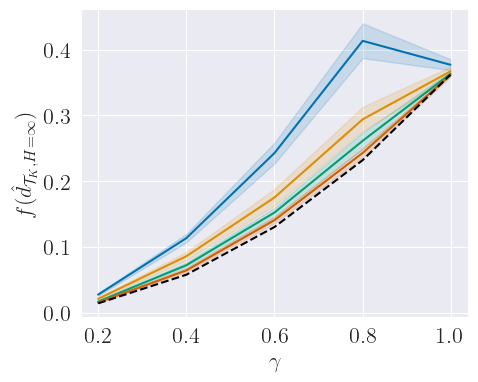

In [19]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []

    # print(estimated_fs_dict[gamma_val][k_val].shape)
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/noisy_quadratic_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Merged plot

In [58]:
print(GLOBAL_DATA_ESTIMATED.keys())
print(GLOBAL_DATA_TRUE.keys())

dict_keys(['entropy', 'imitation', 'quadratic'])
dict_keys(['entropy', 'imitation', 'quadratic'])


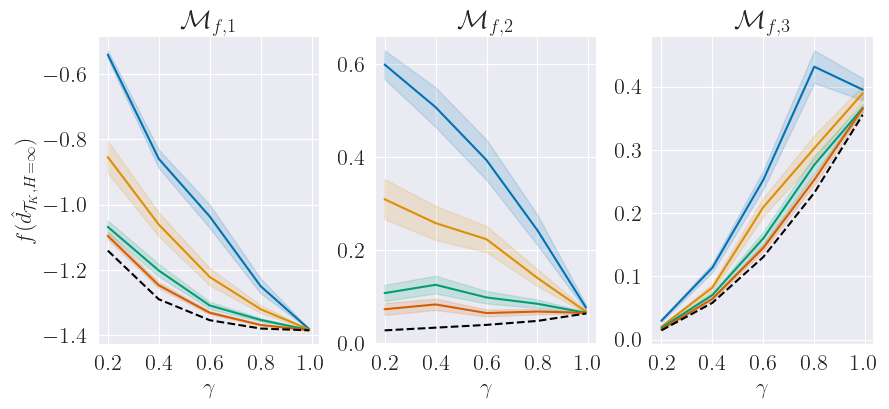

In [59]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.25, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

titles = {'entropy': r'$\mathcal{M}_{f,1}$', 'imitation': r'$\mathcal{M}_{f,2}$', 'quadratic': r'$\mathcal{M}_{f,3}$'}

for ax, (mdp_type, estimated_fs_dict) in zip(axs.flat, GLOBAL_DATA_ESTIMATED.items()):
    
    for k_val in k_vals:
    
        ys = []
        upper_cis = []
        lower_cis = []
        
        for gamma_val in gammas:
            ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))
    
            cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
            cis = np.array(cis)
            lower_cis.append(cis[0])
            upper_cis.append(cis[1])
    
        p = ax.plot(gammas, ys, label=rf"$K={k_val}$")
        ax.fill_between(gammas, lower_cis, upper_cis,
                                color=p[0].get_color(), alpha=0.15)
    
    true_fs = [GLOBAL_DATA_TRUE[mdp_type][gamma] for gamma in gammas]
    
    ax.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    ax.set_xlabel(r'$\gamma$')
    ax.set_xticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_title(titles[mdp_type])

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')

plt.savefig(f'figs/noisy_gammas_merged_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()